# Importing Libraries

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.callbacks import Callback,EarlyStopping

2022-02-09 01:03:17.991673: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


# Load Dataset

In [2]:
path = '../input/surface-crack-detection/'
path_all = list(glob.glob(path+'**/*jpg'))
path_Negative = path + 'Negative/*.jpg'
path_Positive = path + 'Positive/*.jpg'

# Visualizing the Dataset

Text(0.5, 1.0, 'Negative and Positive')

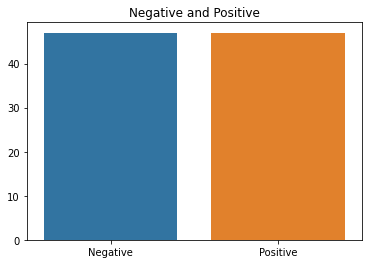

In [3]:
sns.barplot(x=['Negative','Positive'], y=[len(path_Negative), len(path_Positive)])
plt.title('Negative and Positive')

In [4]:
labels = list(map(lambda x:os.path.split(os.path.split(x)[0])[1], path_all))
file_Path = pd.Series(path_all, name='File_Path').astype(str)
labels = pd.Series(labels, name='Label')
data = pd.concat([file_Path, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,File_Path,Label
0,../input/surface-crack-detection/Negative/0510...,Negative
1,../input/surface-crack-detection/Positive/1527...,Positive
2,../input/surface-crack-detection/Negative/0361...,Negative
3,../input/surface-crack-detection/Positive/0325...,Positive
4,../input/surface-crack-detection/Negative/1069...,Negative


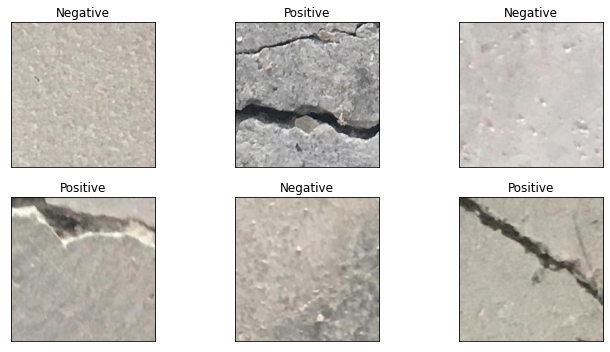

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(10,5), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.File_Path[i]))
    ax.set_title(data.Label[i])
plt.tight_layout()
plt.show()

# Train & Test Split

In [6]:
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)

# Functions

In [7]:
def gen(pre,train,test):
    train_datagen = ImageDataGenerator(
                        preprocessing_function=pre,
                        validation_split=0.2)
    test_datagen = ImageDataGenerator(
                        preprocessing_function=pre)
    
    train_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='File_Path',
        y_col='Label',
        target_size=(100,100),
        class_mode='categorical',
        batch_size=64,
        subset='training',
        shuffle=True,
        seed=42
        )
    valid_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='File_Path',
        y_col='Label',
        target_size=(100,100),
        class_mode='categorical',
        batch_size=64,
        subset='validation',
        shuffle=False,
        seed=42
    )
    test_gen = test_datagen.flow_from_dataframe(
        dataframe=test,
        x_col='File_Path',
        y_col='Label',
        target_size=(100,100),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=64,
        shuffle=False
    )
    return train_gen, valid_gen, test_gen

In [8]:
def func(name_model):
    pre_model = name_model(input_shape=(100,100, 3),
                   include_top=False,
                   weights='imagenet',
                   pooling='avg')
    pre_model.trainable = False
    inputs = pre_model.input

    x = Dense(64, activation='relu')(pre_model.output)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(2, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss = 'categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
    my_callbacks  = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=1,
                              mode='auto')]
    return model, my_callbacks

In [9]:
def plot(history,df_test,test_gen,train_gen):
    # Plotting Accuracy, val_accuracy, loss, val_loss
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax = ax.ravel()

    for i, met in enumerate(['accuracy', 'loss']):
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['train', 'val'])
        
    # Predict Data Test
    pred = model.predict(test_gen )
    pred = np.argmax(pred,axis=1)
    labels = (train_gen.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]
    
    # Classification report
    cm=confusion_matrix(df_test.Label,pred)
    clr = classification_report(df_test.Label, pred, target_names=["NEGATIVE", "POSITIVE"])
    print(clr)
    # Display 6 picture of the dataset with their labels
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(df_test.File_Path.iloc[i+1]))
        ax.set_title(f"True: {df_test.Label.iloc[i+1]}\nPredicted: {pred[i+1]}")
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(6,6))
    sns.heatmap(cm,annot=True,fmt='g',vmin=0,cmap='Blues',cbar=False)
    plt.xticks(ticks=np.arange(2)+.5,labels = ['NEGATIVE','POSITIVE'])
    plt.yticks(ticks=np.arange(2)+.5,labels = ['NEGATIVE','POSITIVE'])
    plt.xlabel("predicted")
    plt.ylabel("actual")
    plt.show()
    return cm

In [10]:
def result_test(test,model_use):
    results = model_use.evaluate(test, verbose=0)
    
    print("    Test Loss: {:.5f}".format(results[0]))
    print("Test Accuracy: {:.2f}%".format(results[1] * 100))
    
    return results

# CNN with no Transfer Learning

In [11]:
train_datagen = ImageDataGenerator(
                        validation_split=0.2)
test_datagen = ImageDataGenerator()
    
train_gen = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='File_Path',
        y_col='Label',
        target_size=(100,100),
        class_mode='categorical',
        batch_size=64,
        subset='training',
        shuffle=True,
        seed=42
        )
valid_gen = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='File_Path',
        y_col='Label',
        target_size=(100,100),
        class_mode='categorical',
        batch_size=64,
        subset='validation',
        shuffle=False,
        seed=42
    )
test_gen = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col='File_Path',
        y_col='Label',
        target_size=(100,100),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=64,
        shuffle=False
    )


Found 25600 validated image filenames belonging to 2 classes.
Found 6400 validated image filenames belonging to 2 classes.
Found 8000 validated image filenames belonging to 2 classes.


In [12]:
# import keras
# import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout,BatchNormalization 

model = Sequential()
model.add(Conv2D(64,3,padding="same", activation="relu", input_shape = (100,100,3)))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(128, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Flatten())
model.add(Dense(256,activation="relu"))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(2, activation="softmax"))

model.summary()

2022-02-09 01:04:43.544813: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-09 01:04:43.549469: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-02-09 01:04:43.592885: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-09 01:04:43.593878: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2022-02-09 01:04:43.593930: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-02-09 01:04:43.648964: I tensorflow/stream_executor/platform/def

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0

In [13]:
model.compile(loss = 'categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
my_callbacks  = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=1,
                              mode='auto')]

history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=10,
    callbacks=my_callbacks
)

2022-02-09 01:04:46.903329: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-02-09 01:04:46.908383: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2199995000 Hz


Epoch 1/10


2022-02-09 01:04:47.776373: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-02-09 01:04:48.842436: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-02-09 01:04:48.893460: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


400/400 [==============================] - 173s 413ms/step - loss: 0.5938 - accuracy: 0.6424 - val_loss: 0.0827 - val_accuracy: 0.9767
Epoch 2/10
400/400 [==============================] - 58s 144ms/step - loss: 0.0717 - accuracy: 0.9778 - val_loss: 0.0533 - val_accuracy: 0.9806
Epoch 3/10
400/400 [==============================] - 57s 144ms/step - loss: 0.0571 - accuracy: 0.9816 - val_loss: 0.0407 - val_accuracy: 0.9864
Epoch 4/10
400/400 [==============================] - 57s 143ms/step - loss: 0.0496 - accuracy: 0.9845 - val_loss: 5.8371 - val_accuracy: 0.8344


              precision    recall  f1-score   support

    NEGATIVE       0.74      1.00      0.85      3939
    POSITIVE       1.00      0.66      0.79      4061

    accuracy                           0.83      8000
   macro avg       0.87      0.83      0.82      8000
weighted avg       0.87      0.83      0.82      8000



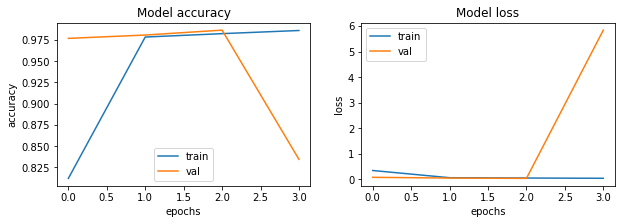

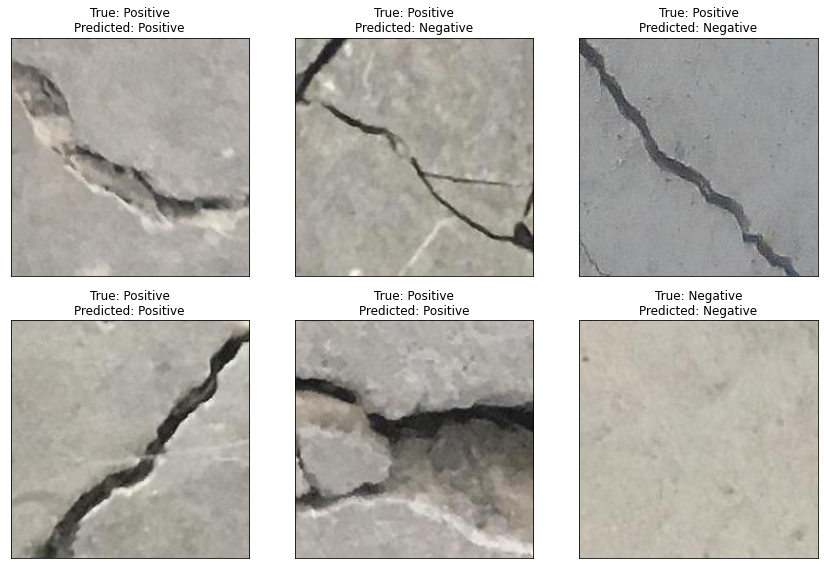

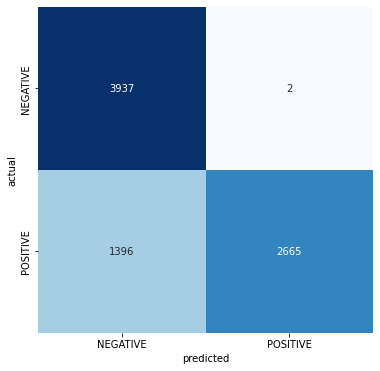

In [14]:
result_CNN=plot(history,test_df,test_gen,train_gen)

In [15]:
(result_CNN[1][1] + result_CNN[0][0] )/np.sum(result_CNN)

0.82525

# VGG16

In [16]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

vgg_pre=preprocess_input
train_gen_VGG, valid_gen_VGG, test_gen_VGG = gen(vgg_pre,train_df,test_df)

Found 25600 validated image filenames belonging to 2 classes.
Found 6400 validated image filenames belonging to 2 classes.
Found 8000 validated image filenames belonging to 2 classes.


In [17]:
model, callback=func(VGG16)
model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
______________________________________________________________

In [18]:
history = model.fit(
    train_gen_VGG,
    validation_data=valid_gen_VGG,
    epochs=10,
    callbacks=callback
)
# batch_size = 128
# history = model.fit_generator(
#     train_gen_VGG,
#     steps_per_epoch = train_gen_VGG.samples // batch_size,
#     validation_data = valid_gen_VGG, 
#     validation_steps = valid_gen_VGG.samples // batch_size,
#     epochs = 10,
#     callbacks=callback)

Epoch 1/10
400/400 [==============================] - 66s 161ms/step - loss: 0.1187 - accuracy: 0.9567 - val_loss: 0.0111 - val_accuracy: 0.9966
Epoch 2/10
400/400 [==============================] - 65s 163ms/step - loss: 0.0056 - accuracy: 0.9985 - val_loss: 0.0089 - val_accuracy: 0.9973
Epoch 3/10
400/400 [==============================] - 65s 162ms/step - loss: 0.0038 - accuracy: 0.9988 - val_loss: 0.0090 - val_accuracy: 0.9973


              precision    recall  f1-score   support

    NEGATIVE       1.00      1.00      1.00      3939
    POSITIVE       1.00      1.00      1.00      4061

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000



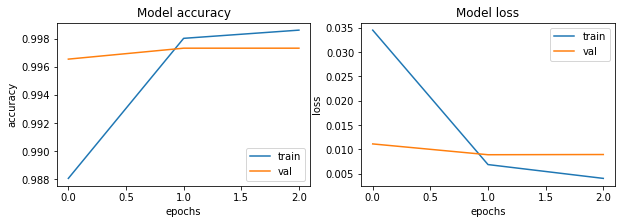

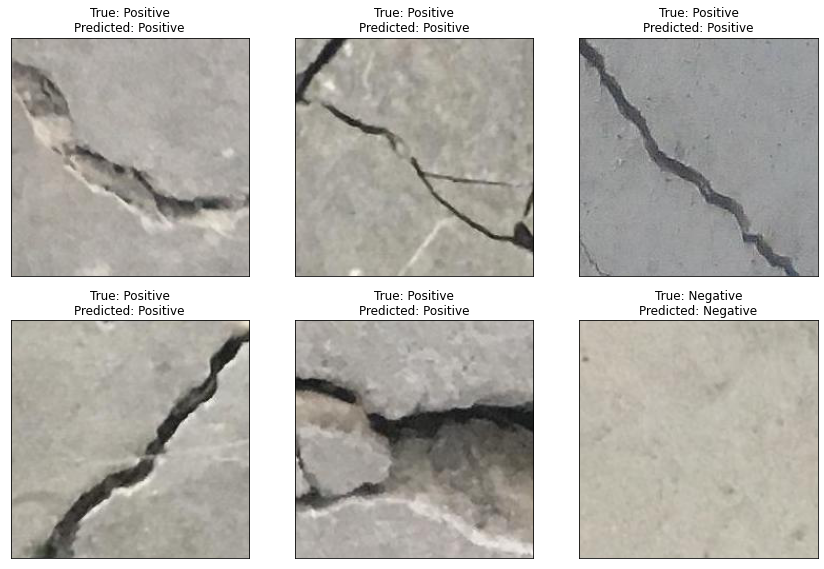

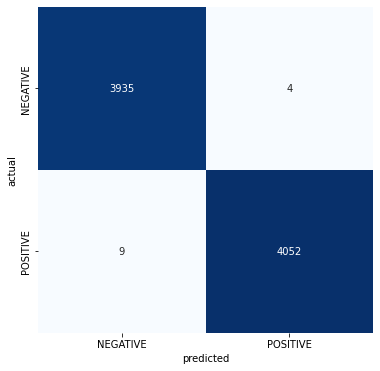

In [19]:
result=plot(history,test_df,test_gen_VGG,train_gen_VGG)

In [20]:
# result = result_test(test_gen_VGG,model)

# ResNet50 

In [21]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
RestNet_pre=preprocess_input
train_gen_RestNet, valid_gen_RestNet, test_gen_RestNet = gen(RestNet_pre,train_df,test_df)

Found 25600 validated image filenames belonging to 2 classes.
Found 6400 validated image filenames belonging to 2 classes.
Found 8000 validated image filenames belonging to 2 classes.


In [22]:
ResNet50_model, callback=func(ResNet50)
ResNet50_model.summary()

94773248/94765736 [==============================] - 2s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 106, 106, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 50, 50, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 50, 50, 64)   256         conv1_conv[0][0]                 
___________________________

In [23]:
history = ResNet50_model.fit(
    train_gen_RestNet,
    validation_data=valid_gen_RestNet,
    epochs=100,
    callbacks=callback
)

Epoch 1/100
400/400 [==============================] - 70s 167ms/step - loss: 0.0338 - accuracy: 0.9879 - val_loss: 0.0066 - val_accuracy: 0.9983
Epoch 2/100
400/400 [==============================] - 66s 165ms/step - loss: 0.0033 - accuracy: 0.9988 - val_loss: 0.0054 - val_accuracy: 0.9991
Epoch 3/100
400/400 [==============================] - 66s 166ms/step - loss: 0.0028 - accuracy: 0.9991 - val_loss: 0.0116 - val_accuracy: 0.9972


              precision    recall  f1-score   support

    NEGATIVE       1.00      1.00      1.00      3939
    POSITIVE       1.00      1.00      1.00      4061

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000



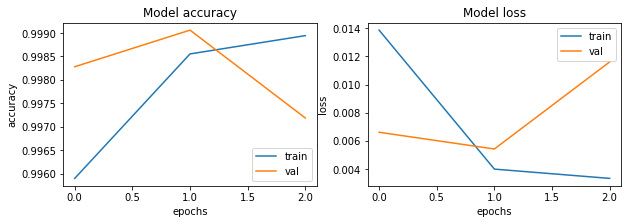

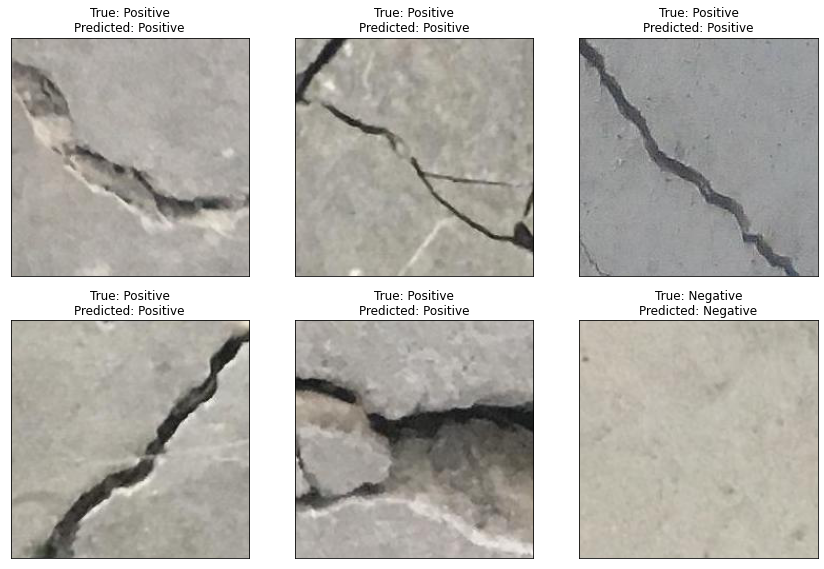

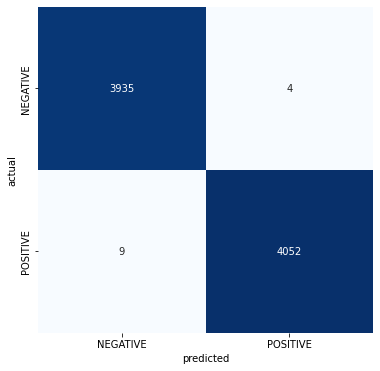

In [24]:
result_ResNet=plot(history,test_df,test_gen_RestNet,train_gen_RestNet)

In [25]:
# result_ResNet = result_test(test_gen_RestNet,ResNet50_model)

In [26]:
# result_ResNet

# Xception

In [27]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input
Xception_pre=preprocess_input
train_gen_Xception, valid_gen_Xception, test_gen_Xception = gen(Xception_pre,train_df,test_df)

Found 25600 validated image filenames belonging to 2 classes.
Found 6400 validated image filenames belonging to 2 classes.
Found 8000 validated image filenames belonging to 2 classes.


In [28]:
Xception_model, callback=func(Xception)
Xception_model.summary()

83689472/83683744 [==============================] - 1s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 49, 49, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 49, 49, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 49, 49, 32)   0           block1_conv1_bn[0][0]            
___________________________

In [29]:
history = Xception_model.fit(
    train_gen_Xception,
    validation_data=valid_gen_Xception,
    epochs=100,
    callbacks=callback
)

Epoch 1/100
400/400 [==============================] - 66s 158ms/step - loss: 0.0935 - accuracy: 0.9770 - val_loss: 0.0132 - val_accuracy: 0.9962
Epoch 2/100
400/400 [==============================] - 63s 158ms/step - loss: 0.0074 - accuracy: 0.9980 - val_loss: 0.0140 - val_accuracy: 0.9962


              precision    recall  f1-score   support

    NEGATIVE       0.52      1.00      0.68      3939
    POSITIVE       1.00      0.09      0.17      4061

    accuracy                           0.54      8000
   macro avg       0.76      0.55      0.42      8000
weighted avg       0.76      0.54      0.42      8000



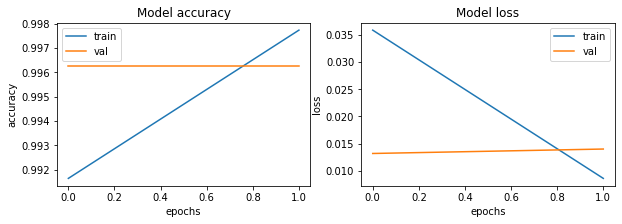

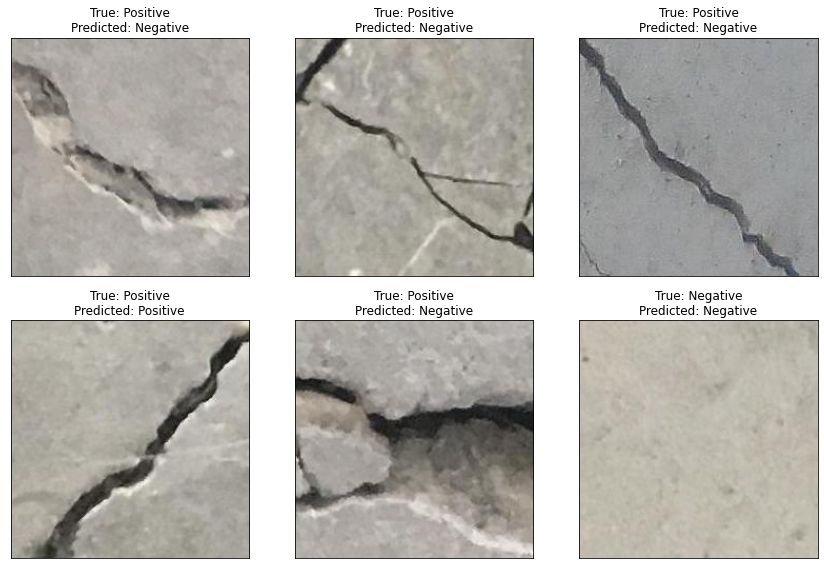

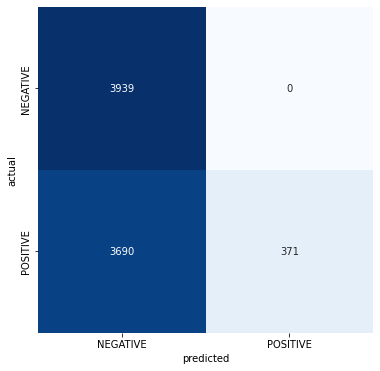

In [30]:
result_Xception=plot(history,test_df,test_gen_Xception,train_gen_Xception)

In [31]:
# result_Xception = result_test(test_gen_Xception,Xception_model)

# MobileNet 

In [32]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
MobileNet_pre=preprocess_input
train_gen_MobileNet, valid_gen_MobileNet, test_gen_MobileNet = gen(MobileNet_pre,train_df,test_df)

Found 25600 validated image filenames belonging to 2 classes.
Found 6400 validated image filenames belonging to 2 classes.
Found 8000 validated image filenames belonging to 2 classes.


In [33]:
MobileNet_model, callback=func(MobileNet)
MobileNet_model.summary()

17227776/17225924 [==============================] - 0s 0us/step
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 50, 50, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 50, 50, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 50, 50, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 50, 50, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 50, 50, 32)        128       
____________________________________________________________

In [34]:
history_MobileNet = MobileNet_model.fit(
    train_gen_MobileNet,
    validation_data=valid_gen_MobileNet,
    epochs=100,
    callbacks=callback
)

Epoch 1/100
400/400 [==============================] - 61s 149ms/step - loss: 0.0933 - accuracy: 0.9717 - val_loss: 0.0075 - val_accuracy: 0.9981
Epoch 2/100
400/400 [==============================] - 60s 150ms/step - loss: 0.0029 - accuracy: 0.9991 - val_loss: 0.0106 - val_accuracy: 0.9980


              precision    recall  f1-score   support

    NEGATIVE       0.52      1.00      0.68      3939
    POSITIVE       1.00      0.09      0.17      4061

    accuracy                           0.54      8000
   macro avg       0.76      0.55      0.42      8000
weighted avg       0.76      0.54      0.42      8000



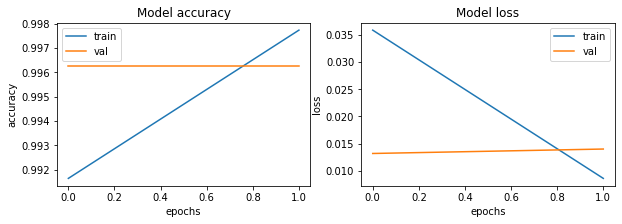

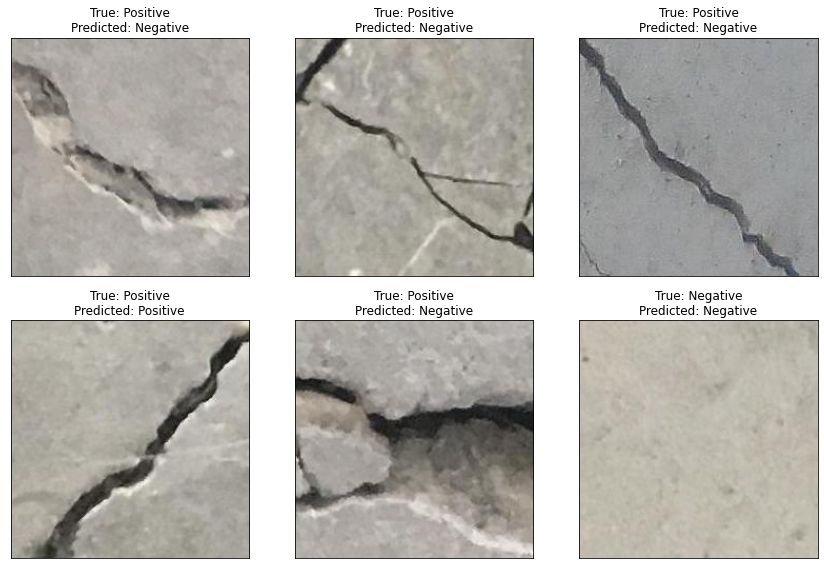

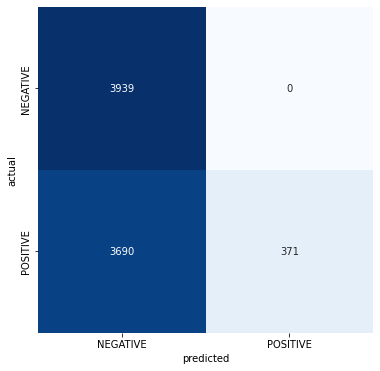

In [35]:
result_MobileNet=plot(history,test_df,test_gen_MobileNet,train_gen_MobileNet)

In [36]:
# result_MobileNet = result_test(test_gen_MobileNet,MobileNet_model)

# Final Report

In [37]:
def de_score(re):
    return (re[1][1]+re[0][0])/np.sum(re)
    

output = pd.DataFrame({'Model':['CNN','VGG16','ResNet50','Xception','MobileNet'],
                      'Accuracy':[de_score(result_CNN), 
                                  de_score(result), de_score(result_ResNet), de_score(result_Xception)
                                  , de_score(result_MobileNet) ] })
print(output)

       Model  Accuracy
0        CNN  0.825250
1      VGG16  0.998375
2   ResNet50  0.998375
3   Xception  0.538750
4  MobileNet  0.538750


In [38]:
output

,Model,Accuracy
0,CNN,0.825250
1,VGG16,0.998375
2,ResNet50,0.998375
3,Xception,0.538750
4,MobileNet,0.538750


(0.5, 1.04829375)

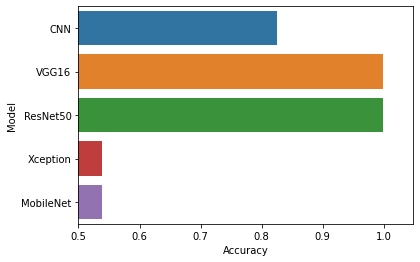

In [39]:
lm = sns.barplot(x='Accuracy', y='Model', data=output)
axes = lm.axes
axes.set_xlim(0.5,)

# End